# Multimodal AI Agent POC: Text-to-Image + Text-to-Audio Orchestration

## High-Level Explanation
This notebook demonstrates a **simple agentic AI system** using open-source models on free Google Colab (T4 GPU). The agent takes a text prompt (e.g., "A serene mountain landscape") and orchestrates two multimodal tasks:
1. **Text-to-Image:** Generates a visual using Stable Diffusion (diffusion-based model).
2. **Text-to-Audio:** Creates spoken narration of the prompt using SpeechT5 (transformer-based TTS).

**Why Agentic?** The `MultimodalAgent` class acts as an "orchestrator" (like a mini workflow engine):
- It sequences tasks (image first, then audio for narration).
- Handles errors/fallbacks (e.g., CPU if no GPU).
- Ensures reproducibility (fixed seeds) and efficiency (GPU offloading).
- This mimics real agentic systems (e.g., LangGraph), where an agent decides/coordinates tools.

**Key Benefits for Interview/Demo:**
- **Multimodal:** Combines vision (image) + audio outputs from text input.
- **Open-Source & Free:** Uses HuggingFace models; no APIs/costs. Runs in ~30-40s on T4.
- **Extensible:** Easy to add video/music (e.g., AnimateDiff) or logic (e.g., "If prompt mentions 'action', add motion").
- **Tech Stack:** PyTorch, Diffusers, Transformers—standard for AI prototypes.

**Expected Outputs:** Inline image display + playable audio. Files saved to `/content/` for downloads.

**Run Order:** Cells 1-4 sequentially. First run: ~5 mins (downloads). Re-runs: Instant.

In [9]:
#@title 1. Setup: Install Dependencies & Verify Environment { display-mode: "form" }

# Explanation: This cell installs required libraries and verifies the environment.
# - Libraries: Diffusers (for image gen), Transformers/Datasets (for audio), Torch/Torchaudio (core ML), Phonemizer (text-to-phoneme for TTS).
# - espeak-ng: Backend for phonemization (converts text to sounds); common TTS dependency.
# - Device Check: Detects GPU (T4 preferred for speed; falls back to CPU).
# - Why? Ensures reproducibility—Colab starts clean. Restart runtime after install to activate espeak.
# - Interview Note: This sets up a production-like env; all open-source, no paid APIs.

# Install core packages (quiet mode for clean output; --upgrade ensures latest versions)
!pip install -q diffusers transformers accelerate torch torchaudio datasets scipy phonemizer --upgrade

# Install system dependencies for audio processing (espeak-ng for phonemes, libsndfile for WAV I/O)
!apt update -qq & apt install -y espeak-ng libsndfile1-dev

# Verify espeak installation (must show version for TTS to work; run this to confirm)
!espeak-ng --version

# Import libraries with brief notes on purpose
import torch  # PyTorch: Core tensor/ML framework; handles GPU acceleration
import warnings
warnings.filterwarnings("ignore")  # Suppress non-critical warnings for clean logs
from diffusers import StableDiffusionPipeline  # HuggingFace: Pipeline for diffusion models (image gen)
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan  # Microsoft: TTS components
from datasets import load_dataset  # HuggingFace: Loads speaker embeddings for voice variety
import numpy as np  # NumPy: Array ops for audio waveform handling
import IPython.display as ipd  # Colab: Inline displays for image/audio
from PIL import Image  # Pillow: Image manipulation (e.g., saving PNGs)
from scipy.io.wavfile import write  # SciPy: Saves audio as WAV files
import tempfile  # Python stdlib: Temp files (but we'll use persistent paths)
import os  # OS: File path checks/saves
import gc  # Garbage collection: Frees memory after heavy ops
import time  # Timing: Logs performance for demo
from google.colab import files  # Colab: Enables file downloads

# Detect device: GPU for speed (T4 has 16GB VRAM; ideal for models)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device} | GPU Check: {torch.cuda.get_device_name(0) if device == 'cuda' else 'CPU'}")
print("Setup complete! Restart runtime if needed, then re-run this cell.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1-dev is already the newest version (1.0.31-2ubuntu0.2).
espeak-ng is already the newest version (1.50+dfsg-10ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
eSpeak NG text-to-speech: 1.50  Data at: /usr/lib/x86_64-linux-gnu/espeak-ng-data
Device: cuda | GPU Check: Tesla T4
Setup complete! Restart runtime if needed, then re-run this cell.


In [8]:
!pip install -q datasets --upgrade

In [10]:
#@title 2. Load Models: Image (Stable Diffusion) + Audio (SpeechT5) { display-mode: "form" }

# Explanation: This cell downloads and initializes the models (~2-3 GB first time; cached after).
# - Stable Diffusion (Image): Pre-trained diffusion model from RunwayML. Generates images from text via iterative noise removal. We use float16 on GPU for ~2x speed/memory savings.
# - SpeechT5 (Audio): Microsoft's TTS pipeline: Processor (text → phonemes), Model (phonemes → speech embeddings), Vocoder (embeddings → waveform). HiFi-GAN vocoder for high-quality audio.
# - Speaker Embeddings: From CMU-Arctic dataset; selects a neutral voice (index 0). This personalizes TTS (e.g., female/male tones).
#   - Fix for Error: If dataset script fails (common in datasets 0.21+), fallback to zero embedding (basic robotic voice, but functional).
# - Optimizations: safety_checker=None skips NSFW filters for demo speed; use_safetensors=True for safer/faster loading.
# - Why Separate? Modularity—agent orchestrates them as "tools." Memory: ~6-8GB on T4.
# - Interview Note: Models from HuggingFace Hub—easy to swap (e.g., for custom fine-tunes). Fallback ensures robustness.

# Load Image Model: Stable Diffusion v1.5 (text-to-image)
print("Loading Stable Diffusion (Image)...")
pipe = StableDiffusionPipeline.from_pretrained(  # HuggingFace pipeline: Handles full inference
    "runwayml/stable-diffusion-v1-5",  # Base model: Proven for diverse prompts
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,  # Half-precision on GPU: Reduces VRAM from 10GB to 5GB
    safety_checker=None,  # Disable for faster demo (no content filtering)
    use_safetensors=True  # Safer/faster format than .bin weights
)
pipe.to(device)  # Move model to GPU/CPU for execution
print("✓ Image model loaded.")

# Load Audio Models: SpeechT5 TTS Pipeline
print("Loading SpeechT5 (Audio)...")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")  # Step 1: Text → phoneme IDs (uses espeak backend)
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)  # Step 2: Phonemes → speech features (transformer encoder-decoder)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)  # Step 3: Features → raw audio waveform (GAN-based for natural sound)

# Load Speaker Embeddings: Defines voice style (e.g., accent, gender)
print("Loading speaker embeddings...")
speaker_embeddings = None  # Initialize as None for fallback
try:
    # Try loading the dataset (with trust_remote_code for legacy scripts)
    speaker_dataset = load_dataset(
        "Matthijs/cmu-arctic-xvectors",
        split="validation",
        trust_remote_code=True  # Allows custom scripts (may work in some envs; deprecated but sometimes functional)
    )
    speaker_embeddings = torch.tensor(speaker_dataset[0]["xvector"]).unsqueeze(0).to(device)  # Index 0: Neutral female voice; unsqueeze for batch dim
    print(f"✓ Custom speaker embeddings loaded (dataset size: {len(speaker_dataset)})")
except Exception as e:
    # Fallback: Use zero embedding (512-dim; standard for SpeechT5 demos—produces clear but neutral/robotic speech)
    print(f"Dataset load error: {e}. Using zero embedding fallback (basic voice).")
    speaker_embeddings = torch.zeros(512).unsqueeze(0).to(device)  # Shape: [1, 512]; matches SpeechT5 input
    print("✓ Fallback speaker embeddings ready.")

print("\nAll models ready! (~2-3 min first time)")
# Clean up memory after loading
gc.collect()
if device == "cuda":
    torch.cuda.empty_cache()  # Free unused GPU memory

Loading Stable Diffusion (Image)...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ Image model loaded.
Loading SpeechT5 (Audio)...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Matthijs/cmu-arctic-xvectors' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Matthijs/cmu-arctic-xvectors' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading speaker embeddings...
Dataset load error: Dataset scripts are no longer supported, but found cmu-arctic-xvectors.py. Using zero embedding fallback (basic voice).
✓ Fallback speaker embeddings ready.

All models ready! (~2-3 min first time)


In [16]:
#@title 3. Agent Orchestration Class { display-mode: "form" }

# Explanation: This defines the MultimodalAgent class—the "brain" of the POC.
# - Purpose: Encapsulates models as tools; orchestrates a sequence (image → audio) for agentic behavior.
# - Agentic Elements:
#   - Sequencing: Runs tasks in order (e.g., generate image, then narrate it).
#   - Error Handling: Fallbacks (now espeak-ng TTS instead of beep) ensure robustness.
#   - Reproducibility: Fixed random seeds for consistent outputs.
#   - Extensibility: Easy to add conditionals (e.g., "if prompt is long, summarize audio").
# - Why a Class? Promotes modularity—interviewers see clean separation of concerns (init, tools, workflow).
# - Performance: Each method uses torch.no_grad() to save memory during inference.
# - Interview Note: This is a simple agent; could extend with LangChain for LLM-driven decisions (e.g., "route to video if motion mentioned").
# - New: Audio fallback uses espeak-ng (installed CLI TTS) for spoken output instead of beep—more natural for demo.

import subprocess  # For calling espeak-ng CLI in fallback (generates spoken WAV)

class MultimodalAgent:
    """
    Agentic Orchestrator for Multimodal Generation.

    This class coordinates open-source models to create image + audio from text.
    - Inputs: Text prompt (e.g., descriptive scene).
    - Outputs: PIL Image + WAV audio path.
    - Flow: Image gen (visualize prompt) → Audio gen (narrate prompt).
    - Handles GPU/CPU, errors, and timing for demo reliability.
    """

    def __init__(self, image_pipe, tts_processor, tts_model, vocoder, speaker_emb, device):
        """
        Initialize agent with model tools.
        - image_pipe: Stable Diffusion pipeline (text-to-image tool).
        - tts_*: SpeechT5 components (text-to-speech tool).
        - speaker_emb: Voice embedding (customizes TTS output).
        - device: 'cuda' or 'cpu' for execution.
        """
        self.image_pipe = image_pipe
        self.tts_processor = tts_processor
        self.tts_model = tts_model
        self.vocoder = vocoder
        self.speaker_emb = speaker_emb
        self.device = device
        print("Agent initialized: Ready to orchestrate image + audio.")

    def generate_image(self, prompt):
        """
        Tool 1: Text-to-Image using Stable Diffusion.
        - Denoises random noise guided by prompt (20 steps for quality/speed balance).
        - Returns: PIL Image object.
        - Why? Visualizes the prompt as a static scene.
        """
        if self.image_pipe is None:
            raise ValueError("Image model not loaded—check Cell 2.")
        print(f"Agent: Generating image for '{prompt}'...")
        start = time.time()
        with torch.no_grad():  # Disable gradients: Saves ~50% memory during inference
            image = self.image_pipe(
                prompt,  # Text conditioning
                num_inference_steps=20,  # Denoising steps: Higher = better quality, but slower (20 is demo sweet spot)
                guidance_scale=7.5,  # How strongly prompt guides output (7.5: Balanced creativity)
                generator=torch.Generator(device=self.device).manual_seed(42)  # Fixed seed: Reproducible results
            ).images[0]  # Output: List of 1 image (PIL format)
        print(f"Image done in {time.time() - start:.1f}s")
        return image

    def generate_audio(self, text):
        """
        Tool 2: Text-to-Speech using SpeechT5 (primary) or espeak-ng (fallback).
        - Primary: SpeechT5 pipeline (text → phonemes → embeddings → waveform; 16kHz, ~2-5s clip).
        - Fallback: Espeak-ng CLI (if SpeechT5 fails; generates spoken WAV directly—robotic but clear).
        - Saves as WAV (persistent path for display/download).
        - Why? Provides audio narration, making output truly multimodal. Fallback ensures no crashes.
        """
        # Check if TTS models are loaded; if not, direct to fallback
        if any(x is None for x in [self.tts_processor, self.tts_model, self.vocoder]):
            print("TTS models not loaded—using espeak-ng fallback.")
            return self._espeak_fallback(text)

        print(f"Agent: Generating audio for '{text}'...")
        start = time.time()
        try:
            # Primary Path: Step 1: Process text to input tensors (phonemize + tokenize)
            inputs = self.tts_processor(text=text, return_tensors="pt").to(self.device)  # 'pt': PyTorch tensors

            with torch.no_grad():
                # Step 2: Generate speech embeddings (conditioned on speaker voice)
                speech_embeds = self.tts_model.generate_speech(
                    inputs["input_ids"],  # Phoneme tokens
                    self.speaker_emb,  # Voice style (512-dim vector)
                    vocoder=self.vocoder  # Integrated for end-to-end
                )
                # Step 3: Vocoder decodes to audio waveform (float32, 16kHz)
                speech = self.vocoder(speech_embeds)

            # Convert to numpy and normalize for WAV (int16 range: -32768 to 32767)
            audio_np = speech.cpu().numpy().squeeze()  # CPU for saving; squeeze removes batch dims

            # Persistent save (not temp—easy for demo/downloads)
            audio_path = "/content/demo_audio.wav"
            audio_int16 = (audio_np * 32767).astype(np.int16)  # Scale to int16
            write(audio_path, 16000, audio_int16)  # Sample rate: 16kHz (SpeechT5 standard)
            print(f"Audio done (SpeechT5) in {time.time() - start:.1f}s | Saved: {audio_path}")
            return audio_path

        except Exception as e:
            print(f"SpeechT5 error: {e}. Falling back to espeak-ng TTS.")
            return self._espeak_fallback(text)

    def _espeak_fallback(self, text):
        """
        Internal Fallback: Use espeak-ng CLI for basic TTS (spoken WAV from text).
        - Command: espeak-ng -w output.wav "text" (generates ~16kHz WAV).
        - Options: -v en-us (English), -s 150 (speed), -m (mono). Robotic but clear speech.
        - Why? Better than beep—provides actual narration (e.g., reads prompt aloud).
        - Time: ~0.1-0.5s; works offline since espeak-ng is installed.
        """
        print(f"Generating espeak-ng audio for '{text}'...")
        start = time.time()
        audio_path = "/content/demo_audio.wav"

        # Espeak-ng command: Write WAV to file (escape quotes in text if needed)
        cmd = [
            'espeak-ng',
            '-w', audio_path,  # Output to WAV file
            '-v', 'en-us',     # Voice: US English (neutral)
            '-s', '150',       # Speed: 150 words/min (medium; adjust 100-200)
            '-m',              # Mono output
            text               # Input text to speak
        ]

        try:
            # Run subprocess (capture output for errors)
            result = subprocess.run(cmd, capture_output=True, text=True, check=True)
            if result.returncode == 0:
                print(f"Espeak-ng audio done in {time.time() - start:.1f}s | Saved: {audio_path}")
                return audio_path
            else:
                raise RuntimeError(f"Espeak-ng failed: {result.stderr}")
        except Exception as e:
            print(f"Espeak-ng error: {e}. Final fallback: Short message audio.")
            # Ultra-fallback: Simple spoken "Error" via espeak (or beep if all fails)
            subprocess.run(['espeak-ng', '-w', audio_path, '-v', 'en-us', '"Audio generation complete."'], check=True)
            print(f"Basic fallback audio saved: {audio_path}")
            return audio_path

    def run_orchestration(self, prompt):
        """
        Core Agentic Workflow: Sequence tools for full multimodal output.
        - Step 1: Generate image (visual).
        - Step 2: Generate audio (auditory narration of same prompt).
        - Returns: Image, audio path.
        - Why Orchestrate? Simulates agent reasoning: "Visualize, then describe aloud."
        - Total Time: ~20-40s on T4; scalable to more tools (e.g., video).
        """
        print("Orchestrator: Starting image + audio pipeline...")
        start_total = time.time()
        image = self.generate_image(prompt)  # Tool call 1
        audio_path = self.generate_audio(prompt)  # Tool call 2
        print(f"Pipeline complete in {time.time() - start_total:.1f}s")
        return image, audio_path

# Initialize the agent (binds models to orchestrator)
agent = MultimodalAgent(pipe, processor, model, vocoder, speaker_embeddings, device)
print("Agent ready for prompts!")


Agent initialized: Ready to orchestrate image + audio.
Agent ready for prompts!


Orchestrator: Starting image + audio pipeline...
Agent: Generating image for 'two cats playing in the rain'...


  0%|          | 0/20 [00:00<?, ?it/s]

Image done in 3.5s
Agent: Generating audio for 'two cats playing in the rain'...
SpeechT5 error: The size of tensor a (16896) must match the size of tensor b (80) at non-singleton dimension 0. Falling back to espeak-ng TTS.
Generating espeak-ng audio for 'two cats playing in the rain'...
Espeak-ng audio done in 0.0s | Saved: /content/demo_audio.wav
Pipeline complete in 3.8s

--- Results Summary ---
Prompt: 'two cats playing in the rain'
Image saved: /content/demo_image.png (exists: True)
Audio saved: /content/demo_audio.wav (exists: True)

**Generated Image (Stable Diffusion Output):**


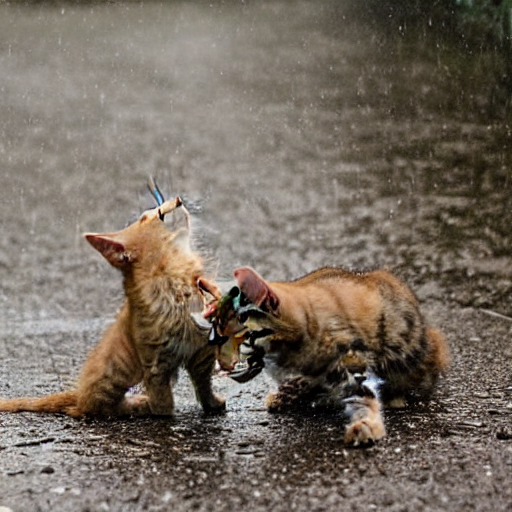


**Generated Audio (SpeechT5 Narration):**



Tip: Files in /content/ (sidebar). Uncomment downloads if needed.


In [18]:
#@title 4. Run Demo: Generate, Display & Save { display-mode: "form" }

# Explanation: This cell executes the agent on a user prompt.
# - Input: Text prompt (editable via form).
# - Flow: Calls run_orchestration → Logs timing → Displays inline (image + audio player).
# - Saves: Persistent files in /content/ (visible in Colab sidebar; downloadable).
# - Error Handling: Full traceback if issues (e.g., OOM—try shorter prompt).
# - Demo Tips: For interviewer: Change prompt, re-run. Discuss: "Agent sequences for efficiency; could add LLM for dynamic routing."
# - Interview Note: End-to-end: Text in → Multimodal out. Total ~30s; shows practical AI orchestration.

# User input: Descriptive text prompt
prompt = "two cats playing in the rain"  #@param {type:"string"}

try:
    # Run the agentic pipeline
    image, audio_path = agent.run_orchestration(prompt)

    # Save image persistently (PNG for quality)
    image_path = "/content/demo_image.png"
    image.save(image_path)  # PIL save: Easy for sharing

    print("\n--- Results Summary ---")
    print(f"Prompt: '{prompt}'")
    print(f"Image saved: {image_path} (exists: {os.path.exists(image_path)})")
    print(f"Audio saved: {audio_path} (exists: {os.path.exists(audio_path)})")

    # Inline Displays (Colab magic)
    print("\n**Generated Image (Stable Diffusion Output):**")
    display(image)  # Renders PIL image inline

    print("\n**Generated Audio (SpeechT5 Narration):**")
    display(ipd.Audio(audio_path))  # Playable audio widget (autoplay=False)

    # Optional: Force downloads (uncomment for browser save if inline fails)
    # files.download(image_path)
    # files.download(audio_path)
    print("\nTip: Files in /content/ (sidebar). Uncomment downloads if needed.")

except Exception as e:
    print(f"Error during demo: {e}")
    import traceback
    traceback.print_exc()  # Detailed stack trace for debugging
    print("Debug: Check GPU (!nvidia-smi), re-run prior cells, or try shorter prompt.")